# Compass Walker dynamics

In [3]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/compasswalker/actinf-compasswalker`


In [4]:
using Base64
using LinearAlgebra
using Distributions
using CairoMakie

In [77]:
# Frames per second
fps = 30;

In [78]:
function display_mp4(filename)
    display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",
    base64encode(open(read,filename)),"""" type="video/mp4"></video>"""))
end

display_mp4 (generic function with 1 method)

## System

![](figures/compass_gait.svg)

States of the robot are the angle of the stance leg, $\theta := \theta_{st}$, the angle of the swing leg, $\eta := \theta_{sw}$, and the changes in angles, $\dot{\theta}, \dot{\eta}$.

In [160]:
# Dynamical parameters
m_h = 10.0  # kg
m   = 5.0   # kg
a   = 0.5   # m
b   = 0.5   # m
l   = a + b # m
γ   = π/6   # radians
cθ  = 0.1   # friction
cη  = 0.1   # friction
const gravity = 9.81

9.81

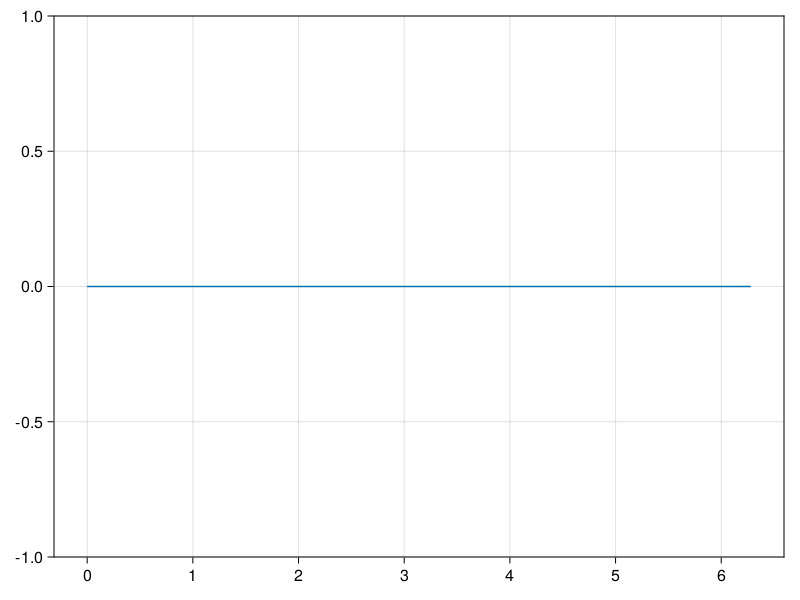

In [161]:
function u(t)
    return 0.0
     # return max(0, sin(t))
end

lines(range(0, stop=2π, step=0.01), t -> u(t))

In [162]:
function dzdt(z,t)
    
    # Unpack state
    θ, η, dθ, dη = z
    
    # Mass matrix
    M = [(m_h+m)*l^2+m*a^2    -m*l*b*cos(θ-η);
          -m*l*b*cos(θ-η)      m*b^2]
    
    # Coriolis matrix
    C = [0                     -m*l*b*sin(θ-η)*dη;
         m*l*b*sin(θ-η)*dθ                      0]
    
    # Gravity terms
    τg = [(m_h*l+m*a+m*l)*gravity*sin(θ)-m*cθ*dθ; -m*b*gravity*sin(η)-m*cη*dη]
    
    # Control matrix
    B = [-1, 1]
    
    return [dθ; dη; inv(M)*(-C*[dθ, dη] + τg + B*u(t))]
end

dzdt (generic function with 2 methods)

In [163]:
function RK4(z,t,dt)

    K1 = dzdt(z,t)
    K2 = dzdt(z + K1*dt/2, t+dt/2)
    K3 = dzdt(z + K2*dt/2, t+dt/2)
    K4 = dzdt(z + K3*dt, t+dt)

    return dt*1/6*(K1 + 2*K2 + 2*K3 + K4)
end

RK4 (generic function with 1 method)

## Animation

In [192]:
function animwalker(θt::Vector{Vector{Float64}}, contact::Vector{Float64})

    f = Figure(resolution=(800,700))
    ax = Axis(f[1, 1])

    # States
    θk = Observable(0.0)
    ηk = Observable(0.0)

    # Slope
    poly!(ax, Point2f[(0, 0), (3, 0), (0, 3tan(γ))])
    CairoMakie.ylims!(ax, [0.,1.])

    # Stance leg
    xk = @lift([contact[1], contact[1] + l*sin($θk)])
    yk = @lift([contact[2], contact[2] + l*cos($θk)])
    lines!(xk, yk, linewidth=5, color=:black)
    
    # Hip joint
    hipx = @lift([contact[1] + l*sin($θk)])
    hipy = @lift([contact[2] + l*cos($θk)])
    CairoMakie.scatter!(hipx, hipy, marker=:circle, markersize=20, color=:red)
    
    # Swing leg
    xk = @lift([contact[1] + l*sin($θk), contact[1] + l*sin($θk) + l*sin($ηk - $θk)])
    yk = @lift([contact[2] + l*cos($θk), contact[2] + l*cos($θk) + l*cos($ηk - $θk)])
    lines!(xk, yk, linewidth=5, color=:black)    
    
    # Set axis properties
    ylims!(-.2, 3.2)
    xlims!(-.2, 3.2)

    # Write animation
    record(f, "passive-compass-walker.mp4", θt; framerate = fps) do θ
        θk[] = θ[1]
        ηk[] = θ[2]
    end
end

animwalker (generic function with 1 method)

In [193]:
Δt = 0.01
time = range(0, stop=2.0, step=Δt)
T = length(time)

201

In [194]:
# Preallocate
z_ = zeros(4,T)

# Initial condition
z_0 = [-0.2, π, 0.4, -2.]
z_kmin1 = z_0

for (n,t) in enumerate(time)
    
    # Forward simulation
    z_[:,n] = z_kmin1 + RK4(z_kmin1, t, Δt)
    z_kmin1 = z_[:,n]
    
end

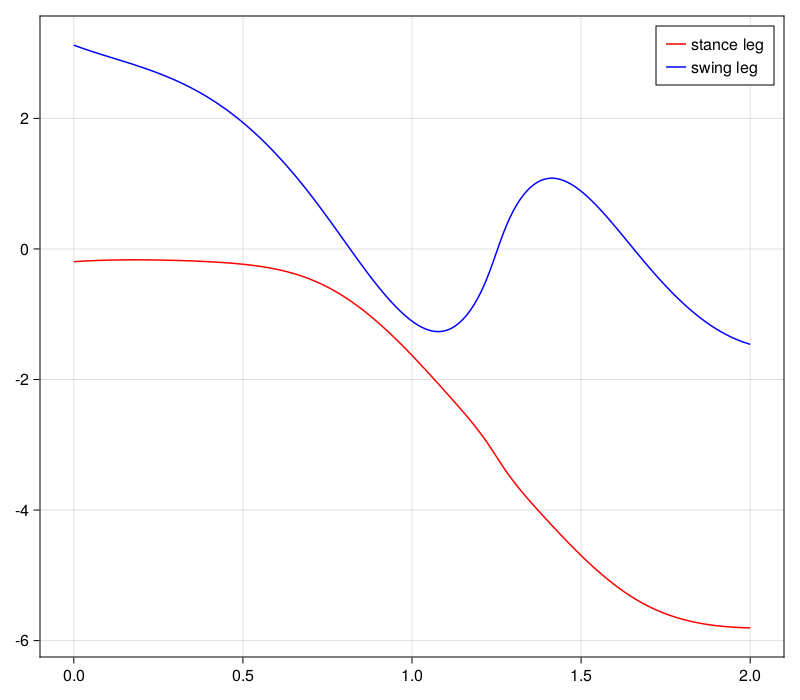

In [195]:
f = Figure(resolution=(800,700))
ax = Axis(f[1, 1])

lines!(ax, time, z_[1,:], color="red", label="stance leg")
lines!(ax, time, z_[2,:], color="blue", label="swing leg")
axislegend(ax)

f

In [198]:
animwalker([z_[1:2,i] for i in 1:T], [1.5, 3tan(γ)/2])

"passive-compass-walker.mp4"

In [199]:
display_mp4("passive-compass-walker.mp4")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAByI9tZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOCBsb29rYWhlYWRfdGhyZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABjUZYiEADP//vdonwKbWkN6fCP3CEv+oFIgo/sJCtDpQaAEkA+JpwDWwH979O6K+DGGZp7MU9IxTAAAAwAAAwAAAwAPFPrsZswsroeSpIXZqMQvx347gCPHyVLAD0eel0ooGts/U1V4IffAYRM+pggDUb1rSkA+Ppz4uNNNim8YQCSSsy+3OB13fPIoYViH5m2qD9pFy/CJ3XFUhd7n6nlGDNXJNqsWY3d9146AGXJsyOvdBV72gHN3FTD6+t9mzTYTu50SS/qyJPottsRrw08pF4AiHsTRRrv2cb6Y+KF2S8CdeJs/UJXDNLNwJJDzztN7wWzhWFXb3da+fCzlZbw0GfxDdJtPx7mIwmwzHl0A8d/n2HdSlY9iP4sm6IrSCk1rc5DD4BcqVrx+K+2TQ2zUKRNO6302F7EowAXs5wiX8UPXr2m/7u4jPcTtyThCYU+ErBHB5SW5BMZC0Ou8QNFlUNvMeCNLxbFzg+jclfoT/0xIIPN7TWc+YWS///c1FafCHNTnaShd0K7L9qSe5ODe1pjQNK3mkBUsmrSvyGU5IQagziHDoYxl7z10hSEfd4Mp6L7+FBMxZLYaQn/vH396S7udlAx/AAAEFQCNgPACKgXYEpBHgO4D3CjcNDaw1hsM9wFhGpONBWQx78A2SsDThplIzGeh6wYZdJlq4vP83mNeT0ADB7ZGkgXAgLdKKVIyo3HogVGe4nU094DV4UVYaUVIC6g168XgcN//6LqAPrQZ/y9lX7OWhm3AW2hbIxtg6Ik4oPCx62NIWAtusDoUSvn3rN7GZL/wLE0BLKQPezjcm01xIF0MDfxf67qv6/Pn2VAJ6FG2kEJSupDtXk2/bG4BVB2fuFQZfYZYS+yDDVcB2zhDkYkXqIWWFuM4fcfhhYd7x7r0ibxfqtiLsDE3Fud1v+3inVLWaZmPZBQ7xz0qNwy7YJoRbN6RSwPy6UA5+vay6XCA3TpgVmZWf62qV6neNsl7N9Tj3hdJvzs4B8WwySaFxr8D1tTWB/Y3+tBhK64QJ2V2ecCMIwqtC8jNz2USLon1zMMT6SDYmjQKCUmAAGpDsJH+bnqBnbAkYm502SzG1TxcaCIann0T67eaAi2+arxL+BMm6Evr9jh62OFEs/KBRt+CgeE6zn1drpSDOQeWL/txaRB1ya+C0HYE4hwadsI4otLccGTYU8aHvDZm1BWXt9WmIjQMBdDdX469Jrl4dlP1l6sJp3k4WTJV3ABhNFBghLKtoLKE3mAWu9CHGwTr06/pebSN5ytd/kWSyNJ3lGIEbT3u+WhdqzwkrBp26zQ+YuGyAbo6EhT8RfHWseN21YgweJ4Qi840us8ZIvKVdfZ/4UcXcfhZgBBcWMpvRAlTT67GMSa0akELYUf73b9rhdtqrrAAhH807OyTnI1FiyCpO6J+SGcrbs54ZAN8s7y/yes4epQq5YIbmoWvimZeR8PD6caCg+bdA57yiP0nursIIDeskF/VYZMTYEK7ztBXn4xk4jAFqLe7knJmdQeAf9ZfnF/IB+QgEgczzug5BAJvGltG2m13iDNUHU2obwB5PKsO1FWfbMoW9R9lFKW07PqTkf4JfglIYM3D0WIglLYP3JVr9E+t3KRxxWzJ+3+YG2I7m9k4T7AyWveCUZEHGy7clJ05g6MMb1wqLWQiNRM8f7vzE5k6h1QYsYKMppT50+rv2zMoeGYwFZile4QJItGnvNMBlkjnIN975ljIjQDqG7l9FxAgzzjFnGDBciiDrboZ+mgCr5YACHL9UudfdaUMQ1Pn8i+PB2R/DW0GlnBOzkX/SQXXRTqFDehpEJPWO6HIsmIjjRzkIPRFG1gan6tQmqX9zcancctZZeslAeFRXOIyp78AY1OGzjIaqnzw+DuuVYjIJtUqKRW+B6x94SzZY538+ZkB979vu8Udb4h6k+S2eu3OQ2WHg3+dmd+nok1vgoMZu0MUwtZ5aZwDxFZOFPL7MCHjsCqiV2XfGkGcmAzsYkb3GKnpVQ/3QyatD8/VVkuDaKR8EDbiSZPYsDBKdConQiufe7x5DsnnAjnt3JxJCVyDj4DeFkXRyAfoSP1yg0U8NvF8VwZMuwKWm5FSJ+G9ecxuQCDnS7LToJdo3gkgenYtXSd/KzxHCMM5SoIfhbc/BiUJ8jzxhbNMQgVc3w5S7MCbKmpxxx+xkkXX6Hghnu5w+gqzph1Y6YpIr5bKRc3f38Hv6npqlt9bmaaWRqToLKfSu9Q+mMbOCun0+e2vTaMrl6KKtR/yhy4GyLmEof9AyWZBxbDIKbeG2ESKgXzfmNuDL/iGFoxn46BUvtB071pXUygAFKOP06yGHMYW5JWEmM17E8p+QCCm4PMnAf7zXA4y+kkoUKrhTJS1PPX9s51d6JWhkPyEbCxglnt8u07tSaEPc1Mknj+voZ/XJaaQWJdj7vuldlZ1nmtOLVUlusDsU2ll+4BFDe7eCcnzqPVPAXWdPGo7WY3DBb5s0EQGYDOEMq72J9ltd0DdC7WU5ZsA54GQgyMNwPTJ+UmAjHgtggl0abgePc86WHhWt92GmlBwdewd6gzrM/UdGV5lQnq4YfwMsGeyjHoFttw5gyKqr9Azn8r5KCKiNlmeEK2IBLy2Hb8cGwk1yukvDCUuRHmjgorZsCqJz1dHyOog5u4TxQWbXW3i1Y7QpR21Ed/MaOda72B/ZNYiUcV3q3RR+DTUl2OG8f9fGEmiDV8gOca4PQxQQP6WujAFMapFTlN4p5wCSaF11Dj3JvfJnPoy5Rf0kDy+vACGXL9PFa475AooDQ3Kdp69CJfplPEzYGOlyRX5avcTex1s5VT0J/mR3CnMdO1Tq0pwAvIl6QYroxWMGKQKF7tnOFQuWMRCfrvAahx7WVUPH6Wmx3hUAh1CNDpV42xIZAZj/F5Pi7isJpq7w8zegQJnNgxMt14AUhl25Tc0/u8NKemG92p/eE46XVaRsZz2AEXx3u0mVlxfc2YL4EeCVV3uEmW